In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from mpl_toolkits.basemap import Basemap
import folium
import folium.plugins
from matplotlib import animation,rc
import io
import base64
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')
from scipy.misc import imread
import codecs
import collections
from subprocess import check_output

## Importing Packages

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import scipy.stats as stats
import os, sys, operator, warnings


# Scikit-learn Auxiliary Modules
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix,recall_score
from sklearn.metrics import explained_variance_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_curve, precision_score, r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, learning_curve, StratifiedKFold, train_test_split, validation_curve 
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Scikit-learn Classification Models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

### 一、数据准备

In [3]:
data=pd.read_excel('./data/basedata.xlsx',encoding='ISO-8859-1')
level=pd.read_csv('./data/level.csv',encoding='ISO-8859-1')
data_columns = [ 
    ## Spatio-Temporal Variables:
                'iyear', 'imonth', 'iday', 'latitude', 'longitude',  
    ## Binary Variables: 
                'extended', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr',
                'multiple', 'success', 'suicide', 'guncertain1', ## check back guncertain
                'claimed', 'property', 'ishostkid',  
    ## Continuous Variables:
                'nkill', 'nwound',                  
    ## Categorical variables (textual): 
                'country', 'region', 'attacktype1', 'targtype1',
                'natlty1', 'weaptype1',     
    ## Descriptive Variables: 
                'targtype1', 'gname']

data['casualities']=data['nkill']+data['nwound']
data=pd.concat([data,level],axis=1)

gtd = data.loc[:, data_columns]
# To avoid confusion, we restrict the dataset to only attacks that were of terrorist nature.
gtd = gtd[(gtd.crit1 == 1) & (gtd.crit2 == 1) & (gtd.crit3 == 1) & (gtd.doubtterr == 0)]

In [4]:
gtd.head(10)

,iyear,imonth,iday,latitude,longitude,extended,vicinity,crit1,crit2,crit3,...,nkill,nwound,country,region,attacktype1,targtype1,natlty1,weaptype1,targtype1,gname
1,1998,1,1,55.751377,37.579914,0,0,1,1,1,...,0.0,3.0,167,9,3,19,167.0,6,19,Unknown
2,1998,1,1,54.607712,-5.956210,0,0,1,1,1,...,1.0,0.0,603,8,2,14,233.0,5,14,Loyalist Volunteer Forces (LVF)
3,1998,1,2,33.303566,44.371773,0,0,1,1,1,...,0.0,0.0,95,10,3,7,999.0,6,7,Unknown
4,1998,1,2,31.995965,35.271110,0,0,1,1,1,...,0.0,1.0,155,10,2,14,97.0,5,14,Unknown
5,1998,1,4,42.135812,21.717896,0,0,1,1,1,...,NaN,NaN,118,9,3,3,118.0,6,3,Kosovo Liberation Army (KLA)
6,1998,1,4,41.351730,21.562140,0,0,1,1,1,...,NaN,NaN,118,9,3,3,118.0,6,3,Kosovo Liberation Army (KLA)
7,1998,1,5,47.070714,15.439504,0,0,1,1,1,...,0.0,0.0,15,8,3,3,15.0,6,3,Unknown
8,1998,1,5,6.821806,-58.159218,0,0,1,1,1,...,0.0,1.0,86,3,3,10,86.0,6,10,Unknown
9,1998,1,5,-2.080109,29.759880,0,0,1,1,1,...,14.0,2.0,168,11,2,14,168.0,5,14,Hutu extremists
10,1998,1,5,-2.080109,29.759880,0,0,1,1,1,...,56.0,2.0,168,11,2,14,168.0,5,14,Hutu extremists


#### 1.剔除丢失数据

In [5]:
gtd.isnull().sum()

iyear             0
imonth            0
iday              0
latitude        715
longitude       715
extended          0
vicinity          0
crit1             0
crit2             0
crit3             0
doubtterr         0
multiple          1
success           0
suicide           0
guncertain1     253
claimed           0
property          0
ishostkid         1
nkill          3079
nwound         6038
country           0
region            0
attacktype1       0
targtype1         0
natlty1        1103
weaptype1         0
targtype1         0
gname             0
dtype: int64

In [6]:
gtd = gtd.dropna()
print(len(gtd))

87528


#### 2.文字数据进行量化

In [7]:
def string_quantization(formal_target,target):
    counter = collections.Counter(formal_target)
    count = sorted(counter.items(),key=lambda x:-x[1])
    words,_=zip(*count)
    words = words[:len(words)]+(' ',)
    word_map = dict(zip(words,range(len(words))))
    to_num = lambda word:word_map.get(word)
    vector = [to_num(po) for po in target]
    return word_map,vector
_,gtd['gname'] = string_quantization(gtd['gname'],gtd['gname'])

In [8]:
gtd.head(10)

,iyear,imonth,iday,latitude,longitude,extended,vicinity,crit1,crit2,crit3,...,nkill,nwound,country,region,attacktype1,targtype1,natlty1,weaptype1,targtype1,gname
1,1998,1,1,55.751377,37.579914,0,0,1,1,1,...,0.0,3.0,167,9,3,19,167.0,6,19,0
2,1998,1,1,54.607712,-5.956210,0,0,1,1,1,...,1.0,0.0,603,8,2,14,233.0,5,14,202
3,1998,1,2,33.303566,44.371773,0,0,1,1,1,...,0.0,0.0,95,10,3,7,999.0,6,7,0
4,1998,1,2,31.995965,35.271110,0,0,1,1,1,...,0.0,1.0,155,10,2,14,97.0,5,14,0
7,1998,1,5,47.070714,15.439504,0,0,1,1,1,...,0.0,0.0,15,8,3,3,15.0,6,3,0
8,1998,1,5,6.821806,-58.159218,0,0,1,1,1,...,0.0,1.0,86,3,3,10,86.0,6,10,0
9,1998,1,5,-2.080109,29.759880,0,0,1,1,1,...,14.0,2.0,168,11,2,14,168.0,5,14,127
10,1998,1,5,-2.080109,29.759880,0,0,1,1,1,...,56.0,2.0,168,11,2,14,168.0,5,14,127
12,1998,1,6,6.821806,-58.159218,0,0,1,1,1,...,0.0,0.0,86,3,3,1,86.0,6,1,0
15,1998,1,7,54.351036,-6.267020,0,0,1,1,1,...,0.0,0.0,603,8,3,14,233.0,6,14,151


# 判断某事件成功与否关联性

## 1.数据挑选

In [8]:
X = gtd.drop(['success'], axis=1)
Y = gtd['success']

In [9]:
pca_model = PCA(n_components=len(X.columns)) 
pca = pca_model.fit(X)

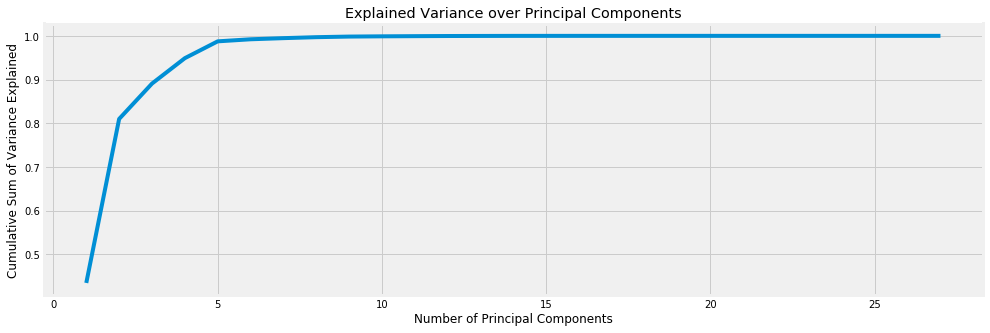

In [10]:
def plot_cumsum_variance(var_ratio):
    '''
    This function plots cummulative explained variance, ranking features by PCA importance.
    '''
    fig = plt.figure(figsize=(15,5))#init figure 
    ax = fig.gca()
    
    x_vals = range(1,len(var_ratio)+1)#set x&y values
    y_vals = var_ratio
    
    ax.set_title('Explained Variance over Principal Components')#set title and labels 
    ax.set_ylabel('Cumulative Sum of Variance Explained')
    ax.set_xlabel('Number of Principal Components')
    
    ax.plot(x_vals, y_vals)
var_ratio = pca.explained_variance_ratio_
var_ratio = np.cumsum(var_ratio)
plot_cumsum_variance(var_ratio)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



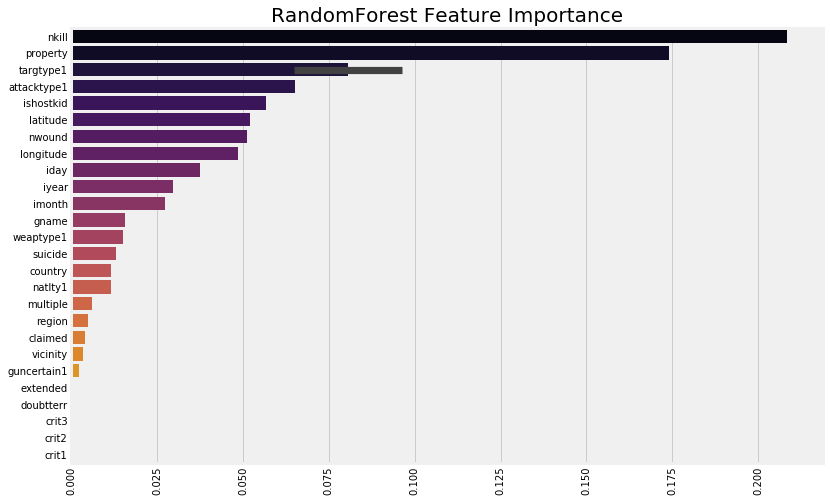

In [11]:
#随机森林进行参数特征排序
from sklearn.cross_validation import cross_val_score, ShuffleSplit  
from sklearn.datasets import load_boston  
from sklearn.ensemble import RandomForestRegressor  
  
#Load boston housing dataset as an example  
boston = load_boston()
names = X.columns 

rf = RandomForestRegressor()
rf.fit(X.values,Y.values)
df = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
df = pd.DataFrame(df, columns=['fscore', 'feature'])

plt.figure()
sns.barplot(df['fscore'].values,df['feature'].values,palette=('inferno'))
plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.title('RandomForest Feature Importance',fontsize=20)
plt.show()

## 2.挑选特征训练

In [24]:
Real_X = X[['property','targtype1','attacktype1','ishostkid','latitude','longitude']]
Y = Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 102)

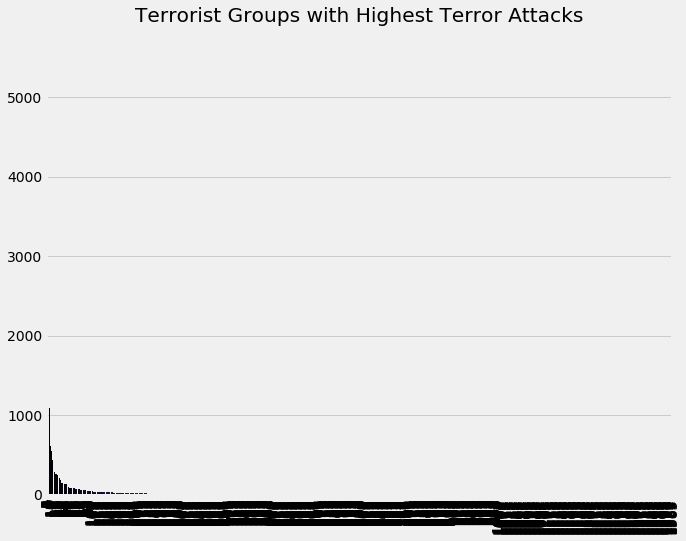

In [25]:
sns.barplot(Y.value_counts().index,Y.value_counts().values,palette=('inferno'))
plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Terrorist Groups with Highest Terror Attacks')
plt.show()

#### 选择多种模型进行训练

In [26]:
vanilla_models = { 
    # Linear Models
    'Logistic Regression' : LogisticRegression(n_jobs = -1, random_state = 56, penalty = 'l1'),
    'Perceptron' : Perceptron(n_iter = 20, n_jobs = -1, random_state= 56),
    'SGD Classifier' : SGDClassifier(penalty = 'l1', n_jobs = -1, random_state= 56),
    # Support Vector Machine
    'Linear SVC' : LinearSVC(penalty = 'l1', random_state = 56, dual = False),
    # Naive Bayes:
    'Gaussian Naive-Bayes' : GaussianNB(),
    # Decision Tree & Ensemble
    'Decision Tree Classifier' : DecisionTreeClassifier(random_state= 56),
    'Random Forest Classifier': RandomForestClassifier(n_jobs = -1, random_state= 56),
    'Gradient Boosting Classifier' : GradientBoostingClassifier(random_state= 56),
    'AdA Boost Classifier': AdaBoostClassifier(random_state = 56),
    'Bagging Classifier' : BaggingClassifier(random_state= 56, n_jobs = -1),
    # K-Nearest Neighbor:
    # Multi-Layer Perceptron (Neural Network):
    'MLP Classifier' : MLPClassifier(activation = 'logistic', random_state = 56, max_iter=400),  
}

In [27]:
score_table = pd.DataFrame(columns = ['model', 'cv_10','f1_score'])


for model, n in zip(vanilla_models, np.arange(len(vanilla_models))):
                    
    clf = Pipeline([
          ('classification', vanilla_models[model]),
        ])
    
    clf.fit(X_train, y_train)
    
    cv_10 = cross_val_score(clf, X_test, y_test, cv = 10, scoring = 'recall').mean()
    f1score = f1_score(np.array(y_test), clf.predict(X_test))
    
    score_table.loc[n,'model'] = model
    score_table.loc[n,'cv_10'] = cv_10
    score_table.loc[n,'f1_score'] = f1score

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

#### 陈列模型准确率，挑选最优模型

In [17]:
score_table.sort_values(by='f1_score', ascending = False)

,model,cv_10,f1_score
6,Random Forest Classifier,0.977394,0.978586
9,Bagging Classifier,0.972846,0.976884
7,Gradient Boosting Classifier,0.972714,0.975281
5,Decision Tree Classifier,0.961576,0.96807
10,MLP Classifier,0.993014,0.966027
8,AdA Boost Classifier,0.977196,0.952485
1,Perceptron,0.988468,0.928609
2,SGD Classifier,0.933834,0.928571
0,Logistic Regression,0.994464,0.92855
3,Linear SVC,0.999143,0.928394


In [18]:
clf = RandomForestClassifier(n_jobs = -1, random_state= 56)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=56, verbose=0, warm_start=False)

In [19]:
from sklearn.metrics import precision_score, recall_score 
y_pred = clf.predict(X_train)
print('recall score: {}'.format(recall_score(y_train, y_pred)))
print('f1 score: {}'.format(f1_score(y_train, y_pred)))

recall score: 0.9981959227854952
f1 score: 0.9984579293600406


In [20]:
confusion_matrix(y_train, y_pred)

array([[ 8971,    78],
       [  110, 60863]], dtype=int64)

# Unknown恐怖组织预测

In [9]:
data_real = gtd.loc[gtd['gname']!=0]
X = data_real.drop(['gname'], axis=1)
Y = data_real['gname']

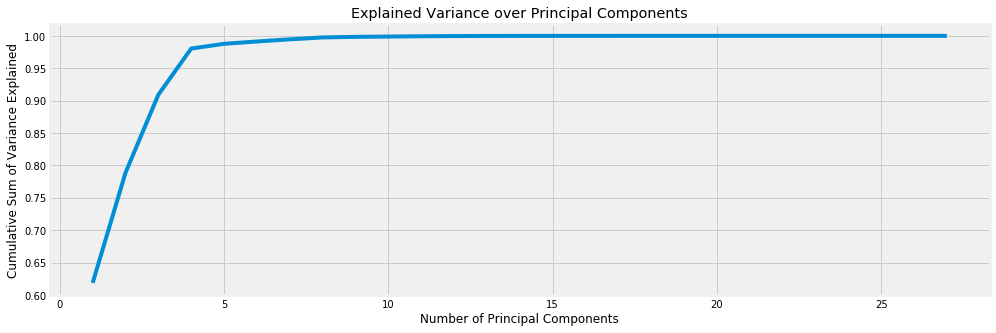

In [10]:
pca_model = PCA(n_components=len(X.columns)) 
pca = pca_model.fit(X)
def plot_cumsum_variance(var_ratio):
    '''
    This function plots cummulative explained variance, ranking features by PCA importance.
    '''
    fig = plt.figure(figsize=(15,5))#init figure 
    ax = fig.gca()
    
    x_vals = range(1,len(var_ratio)+1)#set x&y values
    y_vals = var_ratio
    
    ax.set_title('Explained Variance over Principal Components')#set title and labels 
    ax.set_ylabel('Cumulative Sum of Variance Explained')
    ax.set_xlabel('Number of Principal Components')
    
    ax.plot(x_vals, y_vals)
var_ratio = pca.explained_variance_ratio_
var_ratio = np.cumsum(var_ratio)
plot_cumsum_variance(var_ratio)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



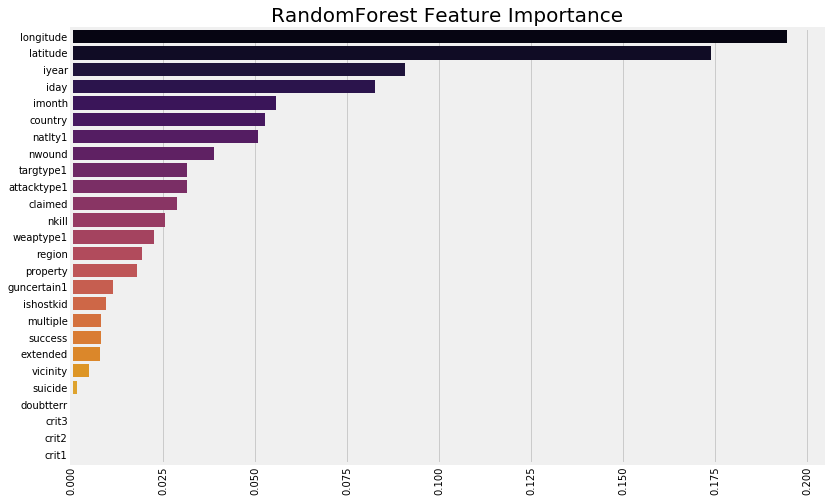

In [11]:
#随机森林进行参数特征排序
from sklearn.cross_validation import cross_val_score, ShuffleSplit  
from sklearn.datasets import load_boston  
from sklearn.ensemble import RandomForestRegressor  
  
#Load boston housing dataset as an example  
boston = load_boston()
names = X.columns 

rf = RandomForestRegressor()
rf.fit(X.values,Y.values)
df = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
df = pd.DataFrame(df, columns=['fscore', 'feature'])

plt.figure()
sns.barplot(df['fscore'].values,df['feature'].values,palette=('inferno'))
plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.title('RandomForest Feature Importance',fontsize=20)
plt.show()

In [13]:
Real_X = X[['longitude','latitude','iyear','country','attacktype1','natlty1']]
Y = Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 102)

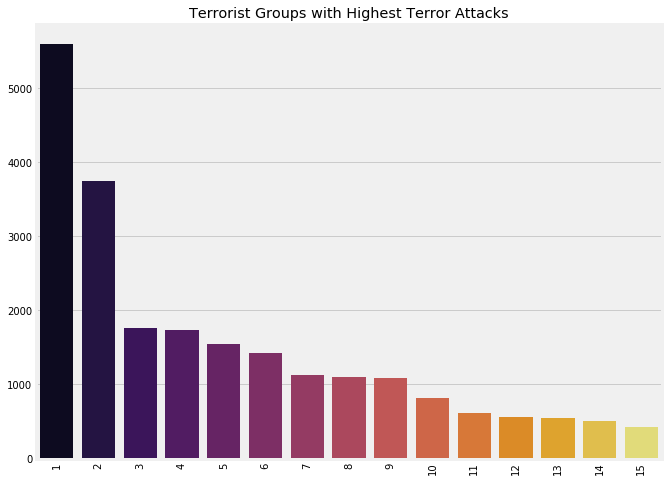

In [14]:
sns.barplot(Y.value_counts()[0:15].index,Y.value_counts()[0:15].values,palette=('inferno'))
plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Terrorist Groups with Highest Terror Attacks')
plt.show()

In [19]:
vanilla_models = {}
vanilla_models = { 
    # Linear Models
#     'Logistic Regression' : LogisticRegression(n_jobs = -1, random_state = 56, penalty = 'l1'),
    'Perceptron' : Perceptron(n_iter = 20, n_jobs = -1, random_state= 56),
    'SGD Classifier' : SGDClassifier(penalty = 'l1', n_jobs = -1, random_state= 56),
    # Support Vector Machine
#     'Linear SVC' : LinearSVC(penalty = 'l1', random_state = 56, dual = False),
    # Naive Bayes:
    'Gaussian Naive-Bayes' : GaussianNB(),
    # Decision Tree & Ensemble
    'Decision Tree Classifier' : DecisionTreeClassifier(random_state= 56),
    'Random Forest Classifier': RandomForestClassifier(n_jobs = -1, random_state= 56,n_estimators=50),
#     'Gradient Boosting Classifier' : GradientBoostingClassifier(random_state= 56),
#     'AdA Boost Classifier': AdaBoostClassifier(random_state = 56),
    'Bagging Classifier' : BaggingClassifier(random_state= 56, n_jobs = -1,n_estimators=50),
    # K-Nearest Neighbor:
    # Multi-Layer Perceptron (Neural Network):
#     'MLP Classifier' : MLPClassifier(activation = 'logistic', random_state = 56, max_iter=400),  
}

In [22]:
def show_accuracy(x,y):
    acc = list(np.equal(x,y)).count(True)/(len(x))
    return acc
#     print(string,' acc=',' ',acc)
score_table = pd.DataFrame(columns = ['model', 'acc','f1_score','recall'])


for model, n in zip(vanilla_models, np.arange(len(vanilla_models))):
                    
    clf = Pipeline([
          ('classification', vanilla_models[model]),
        ])
    
    clf.fit(X_train, y_train)
    
    
#     cv_10 = cross_val_score(clf, X_test, y_test, cv = 10, scoring = 'recall').mean()
    pre_y = clf.predict(X_test)
    recall = recall_score(np.array(y_test), pre_y, average='macro')
    f1score = f1_score(np.array(y_test), pre_y,average='weighted')
    acc = show_accuracy(y_test,pre_y)
    print('***************************************')
    print('Finish training model {}!'.format(model))

    
    score_table.loc[n,'model'] = model
    score_table.loc[n,'acc'] = acc
    score_table.loc[n,'f1_score'] = f1score
    score_table.loc[n,'recall'] = recall

***************************************
Finish training model Perceptron!
***************************************
Finish training model SGD Classifier!
***************************************
Finish training model Gaussian Naive-Bayes!
***************************************
Finish training model Decision Tree Classifier!
***************************************
Finish training model Random Forest Classifier!
***************************************
Finish training model Bagging Classifier!


In [23]:
score_table.sort_values(by='acc', ascending = False)

,model,acc,f1_score,recall
5,Bagging Classifier,0.816695,0.800725,0.353325
4,Random Forest Classifier,0.812315,0.787495,0.33011
3,Decision Tree Classifier,0.759758,0.760709,0.271643
1,SGD Classifier,0.228005,0.207356,0.00889716
0,Perceptron,0.185753,0.151019,0.00747957
2,Gaussian Naive-Bayes,0.139379,0.167931,0.210515


In [43]:
accuracy = []
for i in range(100,120,2):
    clf = BaggingClassifier(random_state= 56, n_jobs = -1,n_estimators=i,oob_score=True)
    clf.fit(X_train,y_train)
    acc = clf.oob_score_
    sys.stdout.write('\r >>Process %d/%f'%(i,acc))
    accuracy.append(np.array([i,acc]))

 >>Process 104/0.821332

KeyboardInterrupt: 

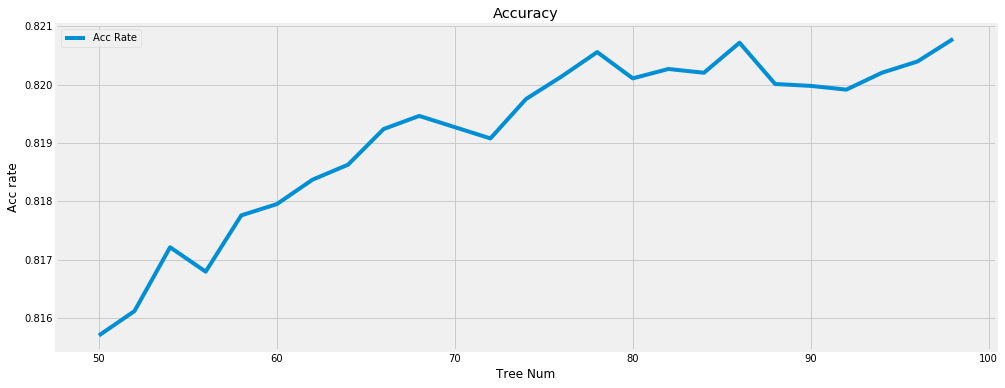

In [42]:
fig=plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,1,1)
acc_array = np.array(accuracy)
plt.plot(acc_array[:,0],acc_array[:,1],label="Acc Rate")
ax.set_title('Accuracy')
ax.set_ylabel('Acc rate')
ax.set_xlabel('Tree Num')
plt.legend()
plt.show()

In [ ]:
clf = BaggingClassifier(random_state= 56, n_jobs = -1,n_estimators=120,oob_score=True)
clf.fit(X_train,y_train)
clf.oob_score_

Exception in thread Thread-434:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\pool.py", line 463, in _handle_results
    task = get()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
_pickle.UnpicklingError: pickle data was truncated

